In [1]:
######################################################################
# Semi-Supervised Classification of Graph Nodes using Exponential Decay
# L42: Assessment 2
# Jan Ondras (jo356), Trinity College
######################################################################
# My Method - MLP_lambda:    training and testing, Cora dataset
######################################################################


#############################################################################################################
# Load data for final training + testing, uses new constructed features
#############################################################################################################

import keras
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import time
from gcn.utils import *

dataset_type = 'cora'

# Load data
_, _, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(dataset_type)

if dataset_type == 'cora':
    N_classes = 7
    N_features = 1433
    N_nodes = 2708
    N_edges = 5278 #5429 - incorrect in paper !
    if N_classes != y_train.shape[1]:
        raise ValueError("Dataset dimensions differ from expected!")
else:
    raise ValueError("Dataset not supported!")
print dataset_type, "dataset:", "#classes =", N_classes, ", #features =", N_features, ", #nodes =", N_nodes, ", #edges =", N_edges

# Prepare labels
y_train = y_train[train_mask]
y_val = y_val[val_mask]
y_test = y_test[test_mask]

train_batch_size = len(y_train)
val_batch_size = len(y_val)
test_batch_size = len(y_test)

print "Labels shapes (train, valid, test):", y_train.shape, y_val.shape, y_test.shape
print y_train.shape[0]*100./N_nodes, y_val.shape[0]*100./N_nodes, y_test.shape[0]*100./N_nodes

Using TensorFlow backend.


cora dataset: #classes = 7 , #features = 1433 , #nodes = 2708 , #edges = 5278
Labels shapes (train, valid, test): (140, 7) (500, 7) (1000, 7)
5.16986706056 18.4638109306 36.9276218612


In [9]:
#############################################################################################################
# Load validation data, from baseline method
#############################################################################################################
from matplotlib import pyplot as plt
import numpy as np

# Using ranges, and parameters from baseline_1: uses best N_hl and N_hu found for the baseline method
data = np.load('./../../../Dataset/baseline_1.npz')
vals = data['vals']
vals_std = data['vals_std']
N_hl_range = data['N_hl_range']
N_hu_range = data['N_hu_range']
N_runs = data['N_runs']
dropout = data['dropout']
epochs = data['epochs']
best_N_hl = N_hl_range[np.argmax(vals) // len(N_hu_range)]
best_N_hu = N_hu_range[np.argmax(vals) % len(N_hu_range)]
# print "# hidden layers range", N_hl_range
# print "# hidden units range", N_hu_range
print "dropout", dropout, "\tN_runs", N_runs
print "Optimal number of hidden layers: ", best_N_hl
print "Optimal number of hidden units: ",  best_N_hu

dropout 0.5 	N_runs 100
Optimal number of hidden layers:  2
Optimal number of hidden units:  60


In [9]:
#############################################################################################################
# Compare 3 feature scaling methods: 0=none, 1=minmax, 2=standard
# DONE
#############################################################################################################

lambdas = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 
           6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 
           100.0, 200.0, 300.0, 400.0, 500.0, 1000.0]
print "Processing", len(lambdas), "lambdas."

val_acc = np.zeros( (3, len(lambdas)) )
val_std = np.zeros( (3, len(lambdas)) )

N_hl = best_N_hl
N_hu = best_N_hu

for ind_lambda, LAMBDA in enumerate(lambdas): 

    st = time.time()
    X = np.load('./../../../Dataset/Features/f_' + str(LAMBDA) + '_.npz')['X']
    if LAMBDA != np.load('./../../../Dataset/Features/f_' + str(LAMBDA) + '_.npz')['LAMBDA']:
        raise ValueError("Lambdas don't agree!")
    print "Max and Min feature value in new feature set:", np.max(X), np.min(X), X.shape

    X_train_org = X[train_mask]
    X_val_org   = X[val_mask]
    X_test_org  = X[test_mask]

    # Feature scaling
    for fs in range(3):
        
        if fs == 0: # none
            X_train = X_train_org 
            X_val = X_val_org
            X_test = X_test_org
            
        elif fs == 1: # minmax
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train_org)
            X_val = scaler.transform(X_val_org)
            X_test = scaler.transform(X_test_org)

        elif fs == 2: # standard
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train_org)
            X_val = scaler.transform(X_val_org)
            X_test = scaler.transform(X_test_org)

        # Train & validate for this feature scaling and LAMBDA
        model = Sequential()
        model.add(Dense(N_hu, activation='relu', kernel_initializer='he_uniform', input_dim=N_features))
        model.add(Dropout(dropout))
        for i in range(1, N_hl):
            model.add(Dense(N_hu, activation='relu', kernel_initializer='he_uniform'))
            model.add(Dropout(dropout))
        model.add(Dense(N_classes, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    #     print model.summary()
        early_stop = EarlyStopping(monitor='val_acc', patience=10, verbose=0) # stop after 10 epochs without improvement in val_acc

        val_acc_actual = []
        for i in range(N_runs):
            model.fit(X_train, y_train, epochs=epochs, batch_size=train_batch_size, 
                       validation_data = (X_val, y_val), verbose=0, callbacks=[early_stop])

            val_acc_actual.append( model.evaluate(X_val, y_val, batch_size=val_batch_size, verbose=0)[1] )

        val_acc[fs][ind_lambda] = np.mean(val_acc_actual)
        val_std[fs][ind_lambda] = np.std(val_acc_actual) 

    print "Time taken: ", time.time()-st, (time.time()-st)/60. # 20sec for one lambda
    
# Save validation results, 1=from baseline_1
np.savez('./../../../Dataset/MyMethodSimple13/mm_feature_scale_1.npz', 
         val_acc=val_acc, val_std=val_std, lambdas=lambdas)

Processing 36 lambdas.
Max and Min feature value in new feature set: 2.95392193694 0.0 (2708, 1433)
Time taken:  271.914408207 4.53194065094
Max and Min feature value in new feature set: 16.9810533074 0.0 (2708, 1433)
Time taken:  221.251850843 3.68754276435
Max and Min feature value in new feature set: 35.7899185129 0.0 (2708, 1433)
Time taken:  240.511692047 4.00853108565
Max and Min feature value in new feature set: 57.6446184281 0.0 (2708, 1433)
Time taken:  262.674843073 4.37791453203
Max and Min feature value in new feature set: 87.3012109762 0.0 (2708, 1433)
Time taken:  237.239970922 3.9540021499
Max and Min feature value in new feature set: 120.116529709 0.0 (2708, 1433)
Time taken:  233.856993914 3.89761961699
Max and Min feature value in new feature set: 153.673386056 0.0 (2708, 1433)
Time taken:  224.185276985 3.73642195066
Max and Min feature value in new feature set: 186.826730194 0.0 (2708, 1433)
Time taken:  228.276834011 3.80461454789
Max and Min feature value in new f

IOError: [Errno 2] No such file or directory: './../../../Dataset/MyMethodSimple13/mm_feature_scale_1.npz'

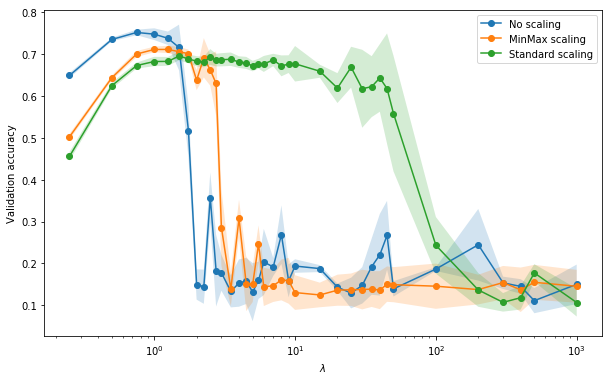

Max validation accuracy:  0.752160000205 for 0.75


In [7]:
#############################################################################################################
# Plot comparing feature scaling methods on validation set
#############################################################################################################

d = np.load('./../../../Dataset/MyMethodSimple/mm_feature_scale_1.npz')
val_acc = d['val_acc']
val_std = d['val_std']
lambdas = d['lambdas']

N_std = 1
showN = 36 # max 36
plt.figure(figsize=[10,6])
for fs in range(3):
    plt.plot(lambdas[:showN], val_acc[fs][:showN],'o-', label='')
    plt.fill_between(lambdas[:showN], 
                     val_acc[fs][:showN]-N_std*val_std[fs][:showN], val_acc[fs][:showN]+N_std*val_std[fs][:showN], alpha=.2)
plt.xlabel('$\lambda$')
plt.xscale('log')
plt.ylabel('Validation accuracy')
plt.legend(['No scaling', 'MinMax scaling', 'Standard scaling'])
plt.show()
print "Max validation accuracy: ",np.max(val_acc), "for", lambdas[np.argmax(val_acc)]

In [6]:
#############################################################################################################
# Final train & Test for each LAMBDA
# Using best N_hl and N_hu found for the baseline method
# no feature scaling
#############################################################################################################
# for all possible lambdas
lambdas = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 
           6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 
           100.0, 200.0, 300.0, 400.0, 500.0, 1000.0]
print "Processing", len(lambdas), "lambdas."

test_acc = []
test_acc_std = []

N_hl = best_N_hl
N_hu = best_N_hu

for LAMBDA in lambdas: 

    st = time.time()
    X = np.load('./../../../Dataset/Features/f_' + str(LAMBDA) + '_.npz')['X']
    if LAMBDA != np.load('./../../../Dataset/Features/f_' + str(LAMBDA) + '_.npz')['LAMBDA']:
        raise ValueError("Lambdas don't agree!")
    print "Max and Min feature value in new feature set:", np.max(X), np.min(X), X.shape

    X_train = X[train_mask]
    X_val   = X[val_mask]
    X_test  = X[test_mask]

    # Train & test for this LAMBDA
    model = Sequential()
    model.add(Dense(N_hu, activation='relu', kernel_initializer='he_uniform', input_dim=N_features))
    model.add(Dropout(dropout))
    for i in range(1, N_hl):
        model.add(Dense(N_hu, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(dropout))
    model.add(Dense(N_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
#     print model.summary()
    early_stop = EarlyStopping(monitor='val_acc', patience=10, verbose=0) # stop after 10 epochs without improvement in val_acc

    test_acc_actual = []
    for i in range(N_runs):
        model.fit(X_train, y_train, epochs=epochs, batch_size=train_batch_size, 
                   validation_data = (X_val, y_val), verbose=0, callbacks=[early_stop])

        test_acc_actual.append( model.evaluate(X_test, y_test, batch_size=test_batch_size, verbose=0)[1] )
        
    test_acc.append( np.mean(test_acc_actual) )
    test_acc_std.append( np.std(test_acc_actual) )  
    
    # Save testing results, 1=from baseline_1, 0=no feature scaling
    np.savez('./../../../Dataset/MyMethodSimple5/mm_simple_1_0_' + str(LAMBDA) + '_.npz', 
             test_acc=test_acc[-1], test_acc_std=test_acc_std[-1], LAMBDA=LAMBDA)
    
    print "Time taken: ", time.time()-st, (time.time()-st)/60. # 20sec for one lambda
    
test_acc = np.array(test_acc)
test_acc_std = np.array(test_acc_std)

Processing 36 lambdas.
Max and Min feature value in new feature set: 2.95392193694 0.0 (2708, 1433)
Time taken:  30.5164749622 0.5086084644
Max and Min feature value in new feature set: 16.9810533074 0.0 (2708, 1433)
Time taken:  31.5843369961 0.526411100229
Max and Min feature value in new feature set: 35.7899185129 0.0 (2708, 1433)
Time taken:  37.2631409168 0.621056167285
Max and Min feature value in new feature set: 57.6446184281 0.0 (2708, 1433)
Time taken:  40.0578320026 0.667633215586
Max and Min feature value in new feature set: 87.3012109762 0.0 (2708, 1433)
Time taken:  37.8735837936 0.631226913134
Max and Min feature value in new feature set: 120.116529709 0.0 (2708, 1433)
Time taken:  40.6572260857 0.677624583244
Max and Min feature value in new feature set: 153.673386056 0.0 (2708, 1433)
Time taken:  42.8477659225 0.714131148656
Max and Min feature value in new feature set: 186.826730194 0.0 (2708, 1433)
Time taken:  38.3981640339 0.639971784751
Max and Min feature value i

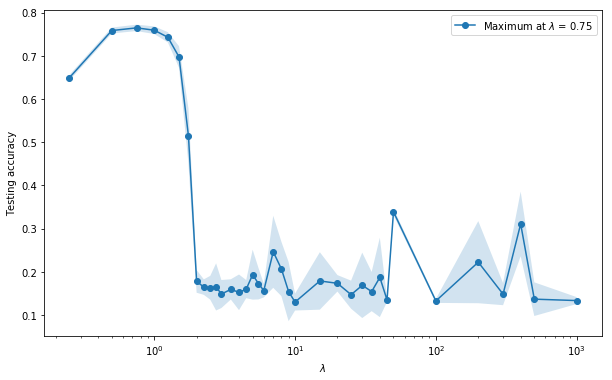

Max Testing accuracy:  0.764490002394 +/- 0.00742629766029 for 0.75

[0.6492599964141845, 0.7583300048112869, 0.7644900023937226, 0.7591000044345856, 0.742719999551773, 0.6971600019931793, 0.514439999461174, 0.17783999979496, 0.16455999985337258, 0.16300999924540518, 0.16495000042021274, 0.14852000042796135, 0.15926000192761422, 0.1524299991130829, 0.15984000079333782, 0.1933000022172928, 0.17240000069141387, 0.15652000091969967, 0.24623000167310238, 0.2065700013935566, 0.15417999938130378, 0.12988000124692917, 0.17877999998629093, 0.17328000023961068, 0.14703000001609326, 0.1686399994790554, 0.154220000654459, 0.18701000176370144, 0.1348099987208843, 0.3386800017952919, 0.1325099990516901, 0.2222400013357401, 0.14826999723911286, 0.3107300028204918, 0.13664000123739242, 0.13336999990046025]
[0.006333435829664597, 0.006852815077747781, 0.007426297660286535, 0.008803977686694069, 0.011894605109274784, 0.02492497843902942, 0.06386428064777548, 0.02631262711524836, 0.017897105853068994, 0

In [16]:
#############################################################################################################
# Show testing results, for chosen lambdas
#############################################################################################################

lambdas = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 
           6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 
           100.0, 200.0, 300.0, 400.0, 500.0, 1000.0]

test_acc = []
test_acc_std = []

for LAMBDA in lambdas:
    d = np.load('./../../../Dataset/MyMethodSimple/mm_simple_1_0_' + str(LAMBDA) + '_.npz') 
    if LAMBDA != d['LAMBDA']:
        raise ValueError("Lambdas don't agree!")
    test_acc.append(d['test_acc'])
    test_acc_std.append(d['test_acc_std'])

test_acc = np.array(test_acc)
test_acc_std = np.array(test_acc_std)

N_std = 1
showN = 36 # max 36
plt.figure(figsize=[10,6])
plt.plot(lambdas[:showN], test_acc[:showN],'o-')
plt.fill_between(lambdas[:showN],  test_acc[:showN]-N_std*test_acc_std[:showN],  test_acc[:showN]+N_std*test_acc_std[:showN], alpha=.2)
# plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('$\lambda$')
plt.ylabel('Testing accuracy')
#plt.xticks(lambdas[:showN], lambdas[:showN])#, rotation=45)
plt.legend(['Maximum at $\lambda$ = '+str(lambdas[np.argmax(test_acc)])])
plt.xscale('log')
plt.show()

print "Max Testing accuracy: ",np.max(test_acc), "+/-", test_acc_std[np.argmax(test_acc)], "for", lambdas[np.argmax(test_acc)]
print ""
print test_acc.tolist()
print test_acc_std.tolist()


In [ ]:
# Saved
Max Testing accuracy:  0.764490002394 +/- 0.0949960128356 for 0.75
[0.6492599964141845, 0.7583300048112869, 0.7644900023937226, 0.7591000044345856, 0.742719999551773, 0.6971600019931793, 0.514439999461174, 0.17783999979496, 0.16455999985337258, 0.16300999924540518, 0.16495000042021274, 0.14852000042796135, 0.15926000192761422, 0.1524299991130829, 0.15984000079333782, 0.1933000022172928, 0.17240000069141387, 0.15652000091969967, 0.24623000167310238, 0.2065700013935566, 0.15417999938130378, 0.12988000124692917, 0.17877999998629093, 0.17328000023961068, 0.14703000001609326, 0.1686399994790554, 0.154220000654459, 0.18701000176370144, 0.1348099987208843, 0.3386800017952919, 0.1325099990516901, 0.2222400013357401, 0.14826999723911286, 0.3107300028204918, 0.13664000123739242, 0.13336999990046025]
[0.006333435829664597, 0.006852815077747781, 0.007426297660286535, 0.008803977686694069, 0.011894605109274784, 0.02492497843902942, 0.06386428064777548, 0.02631262711524836, 0.017897105853068994, 0.027537789253498295, 0.054536296706487804, 0.03243747083091769, 0.0234152177660734, 0.04123984724038146, 0.020984623029340576, 0.05774694666110514, 0.036421421709910036, 0.015862206168430867, 0.0833885915928743, 0.06286036171610634, 0.06850348593560718, 0.01953524098334388, 0.06648437053746964, 0.019063620369356916, 0.03248613767742464, 0.07568943231758667, 0.04540607514882321, 0.0918786694396614, 0.004584092604811652, 0.007577441475311135, 0.004568359437149833, 0.09499601283563656, 0.025603069476197664, 0.07487066962758741, 0.03895703363453094, 0.007968256028387893]

